## **3.2 Google Colab - Algoritmos de mejoramiento de imágenes en el dominio espacial**

Los ejercicios que deben agregarse a este proyecto serán las siguientes:


1.   Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?


2.   Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.


3.   Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes













# **Names and IDs of team members:**

**Nombre Matrícula**

Félix Daniel Reyes López A01794458

Dante Cesar Cervantes Gutierrez A01794585

Ruben Guerrero del Fierro A01793005

Juan Manuel Carballo Montaño A01166758

# **Importing Libraries**

In [1]:
import math
import cv2
import cv2 as cv
import cupy as cp
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

# **Loading images from Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/ComputerVision/Activities/3.2"
os.chdir(DIR)

# **Actividad 1. Implementacion de Prewitt, Sobel y Laplaciano**

Una Convolución es una forma matemática de combinar dos señales para formar una tercer señal. La convolución es una operacion matemática formal como la multiplicacion, suma e integral.
$$ x[n] * h[n] = y[n] $$

Podemos escribir la ecuación estándar para la convolución
$$ (w * f)(x, y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} w(s,t)f(x+s,y+t) $$
donde:
*   `w` es el kernel o filtro
*   `f` es la imagen digital

La implementación simple o naive en python es la siguiente:

In [4]:
def filtro_naive(image, kernel, padding=1):
  # Obtenemos las dimensiones de la imagen y kernel
  Ny, Nx = image.shape
  Ky, Kx = kernel.shape

  # Creamos la matriz de salida
  result = np.zeros((Ny + 2*padding, Nx + 2*padding))
  # Agregamos un padding a la imagen
  padded = np.pad(image, pad_width=(padding, padding))

  # Otenemos las dimensiones finales para iterar sobre la imagen
  rows, cols = Ny - Ky + 2 * padding, Nx - Kx + 2 * padding

  for i in range(rows):
    for j in range(cols):
      # Calculamos el centro del kernel en la imagen
      ii = math.floor((2*i+Ny)/2)
      jj = math.floor((2*j+Nx)/2)
      # Aplicamos la suma y multiplicacion elementwise
      result[ii,jj] = np.sum(padded[i:i+Ny,j:j+Nx] * kernel)
  return result[padding:-padding,padding:-padding]

La implementación del algoritmo de convolucion simple o naive tiene un una complejidad:

$$ O(M \cdot N \cdot m \cdot n) $$

`M` son la filas en la imagen, `N` son las columnas en la imagen, `m` son la filas del kernel y `n` las columnas del kernel.

## Implementación Operadores

Para la implementación de operadores prewitt, sobel y laplace se utilizará la función `apply_2d_filter` como generalización a los kernels aplicados de cada operador. Para la implementación de esta función aplicamos un arreglo a los datos del kernel y de la imagen para formar dos matrices, la primera, una matriz de kernels y la segunda una matriz de ventanas deslizantes.

<img src="https://drive.google.com/uc?export=view&id=1xgyVoQym67qvxP3lzFUWGt3r8-xojjOj" width="450"/>

In [5]:
def apply_2d_filter(image, kernels=(), padding=1):
    """Shapes the image into sliding windows and that result into a transposed matrix where rows
    are the contents of each window and columns are the windows calculated from the sliding_window_view.
    A matrix multiplication is performed for calculating the convolutions.

    Args:
        image (np.ndarray): the image to calculate the operator
        kernels (tuple, optional): the kernel(s) to operate on the image. Defaults to ().
        padding (int, optional): size of the borders added to the image. Defaults to 1.

    Returns:
        np.ndarray: A tensor with the images one per kernel (img, H, W)
    """
    assert image is not None, "Image must not be None"
    assert len(kernels) > 0, "Must be at least one kernel"
    assert all(len(i) == len(kernels[0]) for i in kernels), "Kernels must be of the same size"

    k, kdim = kernels[0].shape, np.prod(np.asarray(kernels[0].shape))

    xp = cp.get_array_module(image)

    # Adds a pad to the borders of each image
    img = xp.pad(image.astype(xp.float32), pad_width=(padding,padding))

    # Shapes the kernels in a single matrix
    kernels = [ xp.reshape(kl, kdim) for kl in kernels ]
    kstack = xp.vstack(kernels).astype(xp.float32)

    # Creates the sliding windows from the image with k size
    views = xp.lib.stride_tricks.sliding_window_view(img, k)
    N = views.shape

    # reshape the view to form a matrix
    stack = xp.reshape(views, (N[0] * N[1], kdim)).T

    # perform the matrix multiplication
    map = kstack @ stack

    # convert back the image from flatten to 2 dims
    res = xp.reshape(map, (map.shape[0], N[0], N[1]))

    return res

In [6]:
def prewitt(img, padding=1):
    # Kernels
    kernel1 = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernel2 = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    # Aplicamos los kernels a la imagen
    flt = apply_2d_filter(img, kernels=(kernel1, kernel2), padding=padding)
    res1, res2 = np.vsplit(flt,2)

    # Aplicamos la distancia euclidea
    res = np.sqrt(np.square(np.squeeze(res1)) + np.square(np.squeeze(res2)))
    return res.astype(np.uint)

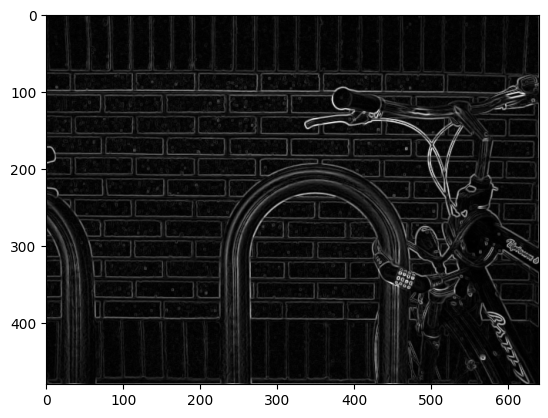

In [7]:
img = cv2.imread('Images/Bikesgray.jpg', cv2.IMREAD_GRAYSCALE)

pwt = prewitt(img)

plt.imshow(pwt, cmap='gray')

In [8]:
def sobel(img, padding=1):
    kernel1 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    kernel2 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

    flt = apply_2d_filter(img, kernels=(kernel1, kernel2), padding=padding)

    res1, res2 = np.vsplit(flt, 2)

    res = np.sqrt(np.square(np.squeeze(res1)) + np.square(np.squeeze(res2)))
    return res.astype(np.uint)

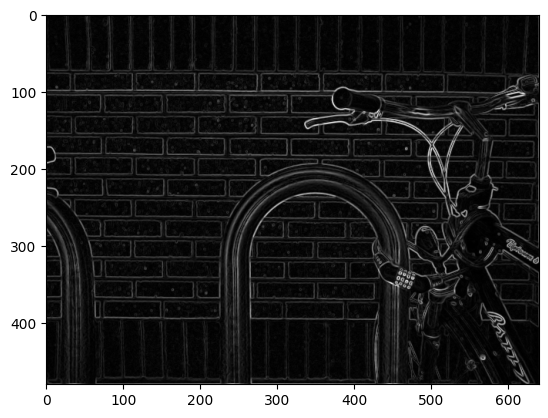

In [9]:
img = cv2.imread('Images/Bikesgray.jpg', cv2.IMREAD_GRAYSCALE)

sbl = sobel(img)

plt.imshow(sbl, cmap='gray')

In [10]:
def laplace(img, padding=1, alpha=0):
    kernel1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

    flt = apply_2d_filter(img, kernels=(kernel1, ), padding=padding)

    return np.squeeze(flt) + alpha

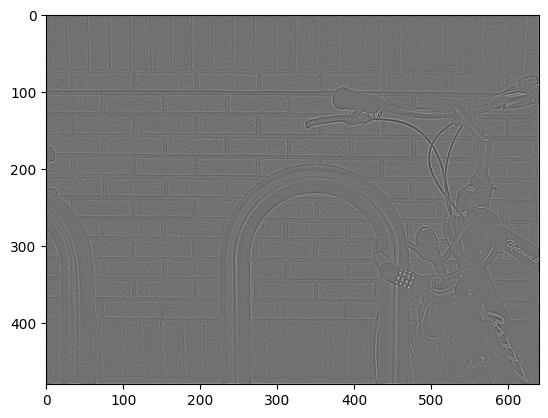

In [11]:
img = cv2.imread('Images/Bikesgray.jpg', cv2.IMREAD_GRAYSCALE)

lpl = laplace(img)

plt.imshow(lpl, cmap='gray')

# **Actividad 2**

Definimos la función para la aplicación del filtro kernel a la imagen deseada:

Para esta actividad, definiremos los kernels laplacianos de tipo c=-1 y c=1, serán 2 de cada uno:

<img src="https://drive.google.com/uc?export=view&id=1dbf7--W9IDhPS_7Nn2jJPgZ2LZfmCBT1" width="450"/>

In [12]:
def apply_filter(img, kernel=None, padding=0):
    img_rows, img_cols = img.shape[0], img.shape[1]
    k_r, k_c = kernel.shape[0], kernel.shape[1]
    rows, cols = img.shape[0] - k_r + 2 * padding + 1, img.shape[1] - k_c + 2 * padding + 1
    res = np.zeros((img_rows + 2*padding, img_cols + 2*padding))
    img_d = np.pad(img, pad_width=(padding, padding))

    for i in range(rows):
        for j in range(cols):
            ii = math.floor((2*i+k_r)/2)
            jj = math.floor((2*j+k_c)/2)
            res[ii,jj] = np.sum(np.multiply(img_d[i:i+k_r,j:j+k_c], kernel))

    return res[padding:-padding, padding:-padding]

Creamos las funciones para cada uno:

In [13]:
def laplace_a(img, padding=1, alpha=1):
    kernel = np.array([[ 0, 1, 0],
                       [ 1,-4, 1],
                       [ 0, 1, 0]])

    res = apply_filter(img, kernel=kernel, padding=padding)

    return res + alpha

In [14]:
def laplace_b(img, padding=1, alpha=1):
    kernel = np.array([[ 1, 1, 1],
                       [ 1,-8, 1],
                       [ 1, 1, 1]])

    res = apply_filter(img, kernel=kernel, padding=padding)

    return res + alpha

In [15]:
def laplace_c(img, padding=1, alpha=1):
    kernel = np.array([[ 0,-1, 0],
                       [-1, 4,-1],
                       [ 0,-1, 0]])

    res = apply_filter(img, kernel=kernel, padding=padding)

    return res + alpha

In [16]:
def laplace_d(img, padding=1, alpha=1):
    kernel = np.array([[-1,-1,-1],
                       [-1, 8,-1],
                       [-1,-1,-1]])

    res = apply_filter(img, kernel=kernel, padding=padding)

    return res + alpha

Obtenemos la imagen original:

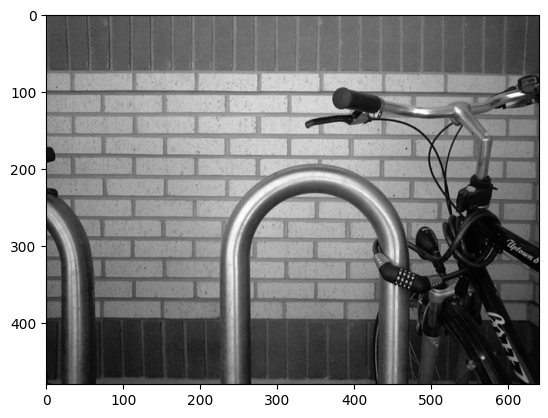

In [17]:
img_bike = cv.imread("Images/Bikesgray.jpg", 0)
plt.imshow(img_bike, cmap='gray')


Aplicamos los filtros kernes laplacianos con un alpha de 5:

In [18]:
alpha = 5

In [19]:
lpl_a = laplace_a(img_bike, alpha=alpha)
lpl_b = laplace_b(img_bike, alpha=alpha)
lpl_c = laplace_c(img_bike, alpha=alpha)
lpl_d = laplace_d(img_bike, alpha=alpha)

Mostramos los resultados  de cada uno:

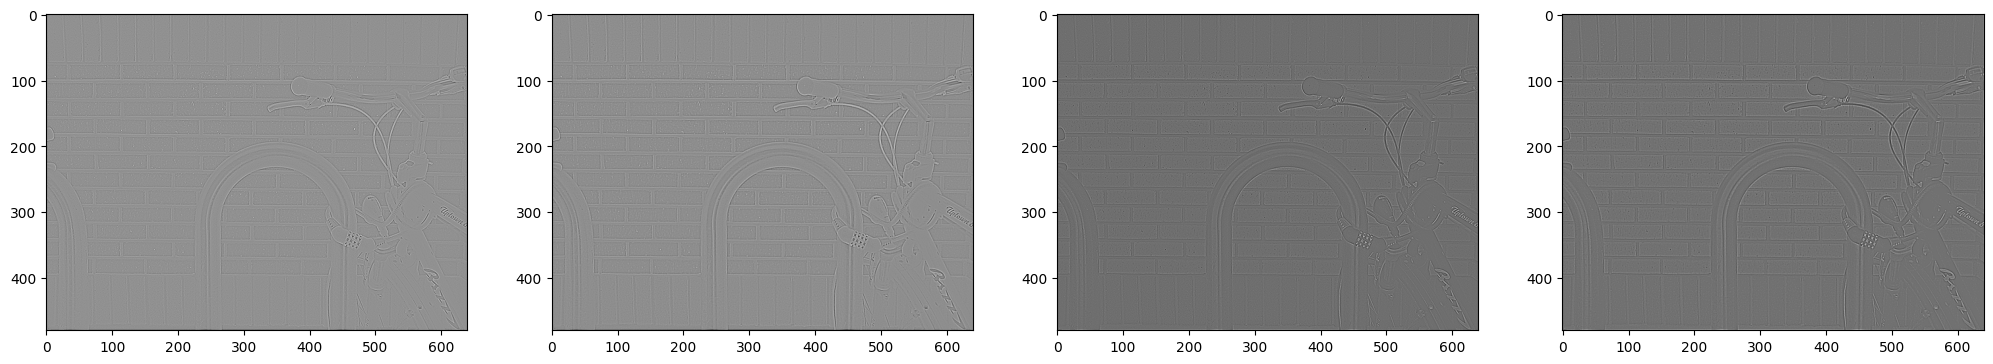

In [20]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for k, i in enumerate([lpl_a,lpl_b,lpl_c,lpl_d]):
    axes[k].imshow(i, cmap='gray')

Los sumamos a la imagen original

In [21]:
img_sharp_a = lpl_a + img_bike
img_sharp_b = lpl_b + img_bike
img_sharp_c = lpl_c + img_bike
img_sharp_d = lpl_d + img_bike

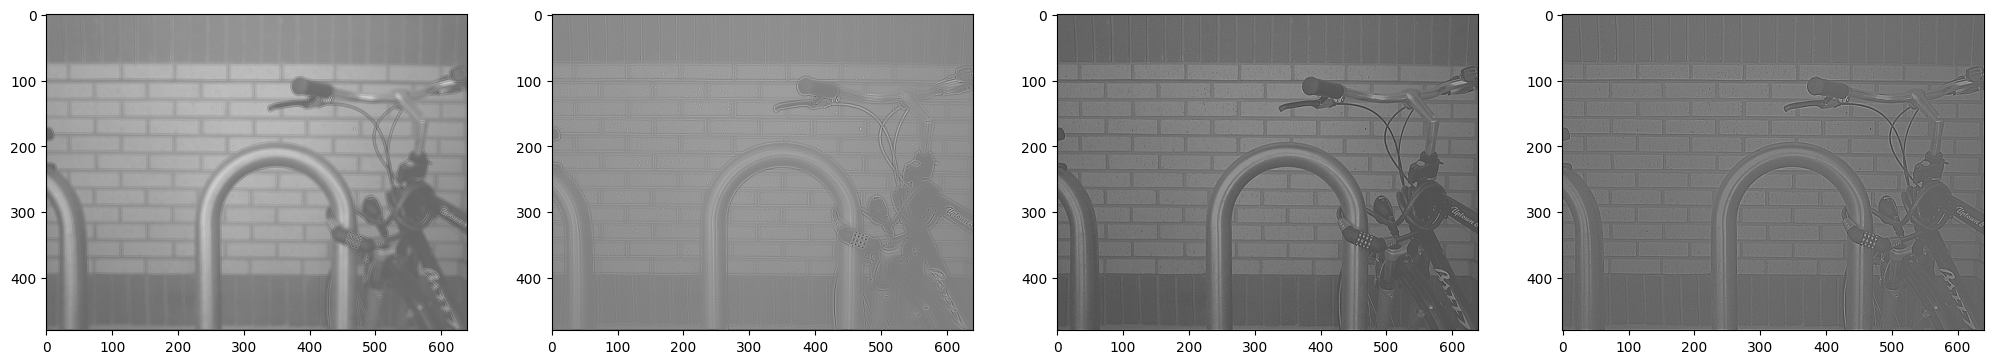

In [22]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for k, i in enumerate([img_sharp_a,img_sharp_b,img_sharp_c,img_sharp_d]):
    axes[k].imshow(i, cmap='gray')


Pero en este punto se tiene el problema que los valores de las matrices de las imágenes son superiores a 255 e inferiores a 0, por la suma directa del filtro con la imagen original:


In [23]:
for i in enumerate([img_sharp_a[0:3,0:3],img_sharp_b[0:3,0:3],img_sharp_c[0:3,0:3],img_sharp_d[0:3,0:3]]):
  print(i)

(0, array([[-67.,  -7.,   6.],
       [ 12.,  80.,  90.],
       [  0.,  95.,  89.]]))
(1, array([[-297., -183., -142.],
       [-139.,   70.,   99.],
       [-163.,   91.,  102.]]))
(2, array([[233., 183., 158.],
       [156.,  94.,  74.],
       [178.,  79.,  79.]]))
(3, array([[463., 359., 306.],
       [307., 104.,  65.],
       [341.,  83.,  66.]]))


Para lo cual se va a aplica una función  para cambiar los valores mayores a 255 a 255 y los valores menores a 0 a 0, np.clip()

In [24]:
img_sharp_clip_a = np.clip(img_sharp_a, 0, 255)
img_sharp_clip_b = np.clip(img_sharp_b, 0, 255)
img_sharp_clip_c = np.clip(img_sharp_c, 0, 255)
img_sharp_clip_d = np.clip(img_sharp_d, 0, 255)

Observamos que ya tenemos valores legibles para ser mostrados como imagen en escala de grises de 0 a 255:

In [25]:
for i in enumerate([img_sharp_clip_a[0:3,0:3],img_sharp_clip_b[0:3,0:3],img_sharp_clip_c[0:3,0:3],img_sharp_clip_d[0:3,0:3]]):
  print(i)

(0, array([[ 0.,  0.,  6.],
       [12., 80., 90.],
       [ 0., 95., 89.]]))
(1, array([[  0.,   0.,   0.],
       [  0.,  70.,  99.],
       [  0.,  91., 102.]]))
(2, array([[233., 183., 158.],
       [156.,  94.,  74.],
       [178.,  79.,  79.]]))
(3, array([[255., 255., 255.],
       [255., 104.,  65.],
       [255.,  83.,  66.]]))


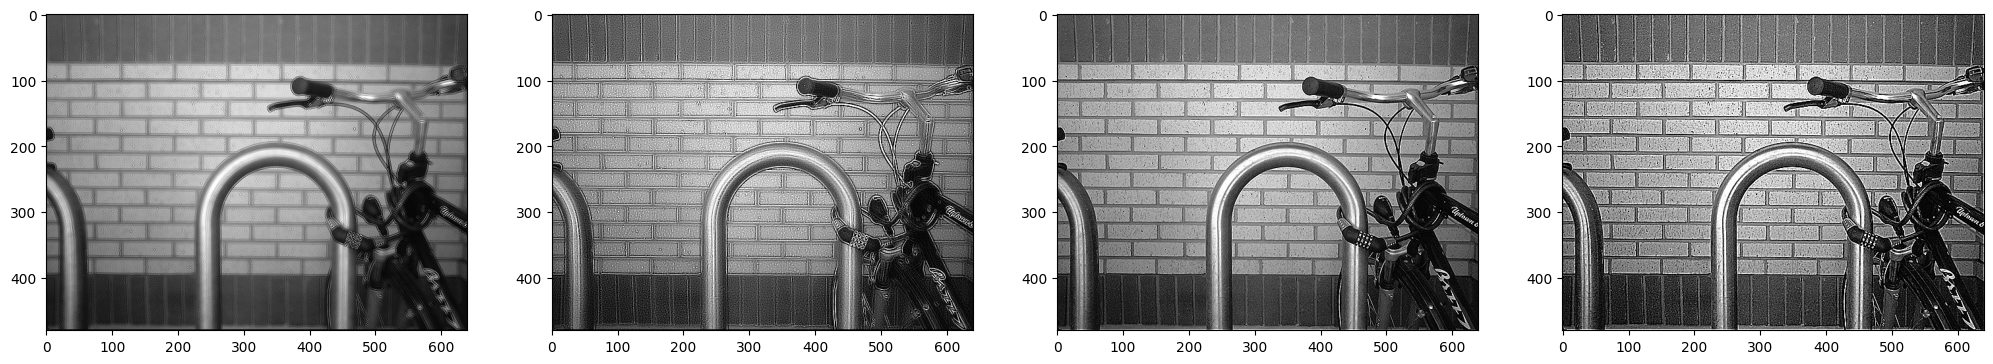

In [26]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for k, i in enumerate([img_sharp_clip_a,img_sharp_clip_b,img_sharp_clip_c,img_sharp_clip_d]):
    axes[k].imshow(i, cmap='gray')

Observamos que la mejor imagen de las 4, la última tuvo mejores resultados, que es el kernel d con valores negativos afuera (-1) y un 8 positivo en el centro

* [-1,-1,-1]
* [-1, 8,-1]
* [-1,-1,-1]

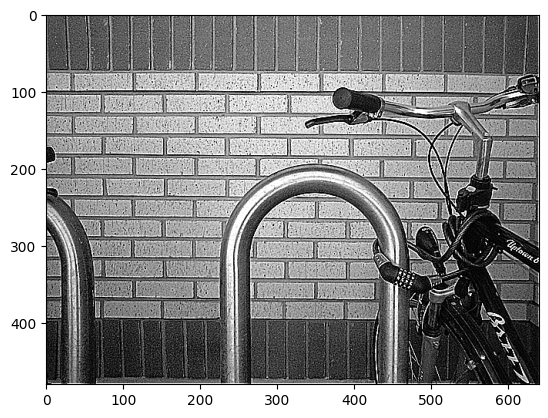

In [27]:
plt.imshow(img_sharp_clip_d, cmap='gray')

**Aplicando Efecto Multiplicador**

Para esta siguiente parte del ejercicio, aplicaremos lo que es el multiplicador al filtro obtenido, se seleccionó un 5 porque los cambios son notorios con respecto a los primeros.

In [28]:
alpha_Multiplicador = 5

In [29]:
lpl_a = laplace_a(img_bike, alpha=3)*alpha_Multiplicador
lpl_b = laplace_b(img_bike, alpha=3)*alpha_Multiplicador
lpl_c = laplace_c(img_bike, alpha=3)*alpha_Multiplicador
lpl_d = laplace_d(img_bike, alpha=3)*alpha_Multiplicador

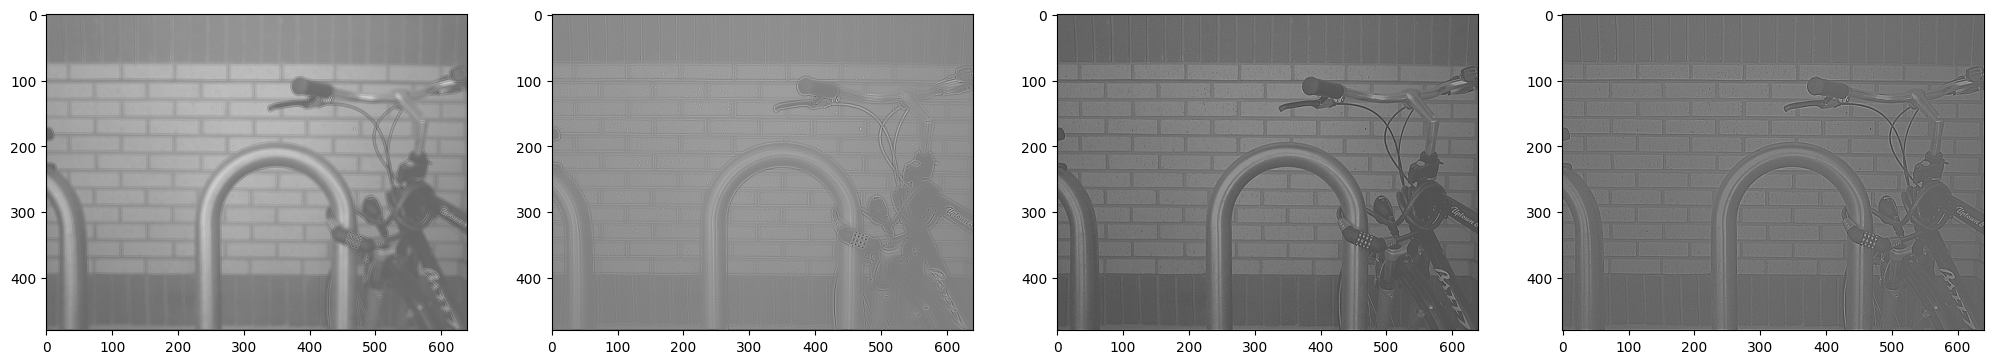

In [30]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for k, i in enumerate([img_sharp_a,img_sharp_b,img_sharp_c,img_sharp_d]):
    axes[k].imshow(i, cmap='gray')

Sumamos el filtro a la imagen original

In [31]:
img_sharp_a = lpl_a + img_bike
img_sharp_b = lpl_b + img_bike
img_sharp_c = lpl_c + img_bike
img_sharp_d = lpl_d + img_bike

Aplicamos limites de 0 a 255:

In [32]:
img_sharp_clip_a = np.clip(img_sharp_a, 0, 255)
img_sharp_clip_b = np.clip(img_sharp_b, 0, 255)
img_sharp_clip_c = np.clip(img_sharp_c, 0, 255)
img_sharp_clip_d = np.clip(img_sharp_d, 0, 255)

Mostramos resultados:

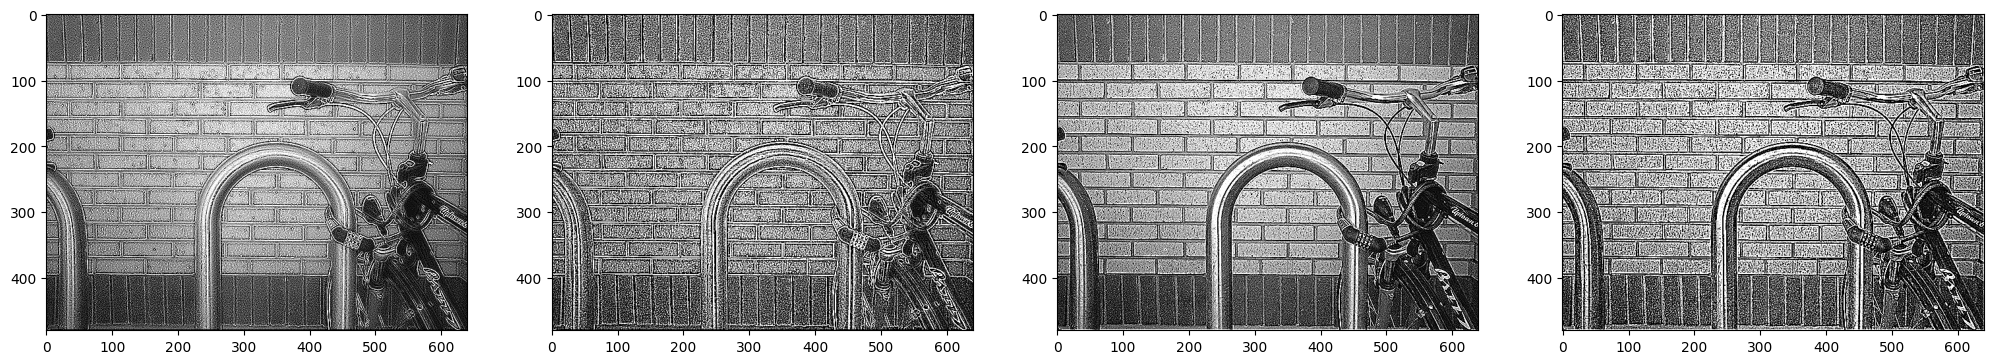

In [33]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for k, i in enumerate([img_sharp_clip_a,img_sharp_clip_b,img_sharp_clip_c,img_sharp_clip_d]):
    axes[k].imshow(i, cmap='gray')

Observamos que con el multiplicador, obetenemos resultados con mayor distorcion, por lo que se pudieran elegir alguno de ellos por el efecto que genera. Aunque de los 4, en este caso, el mejor que se observa es el C

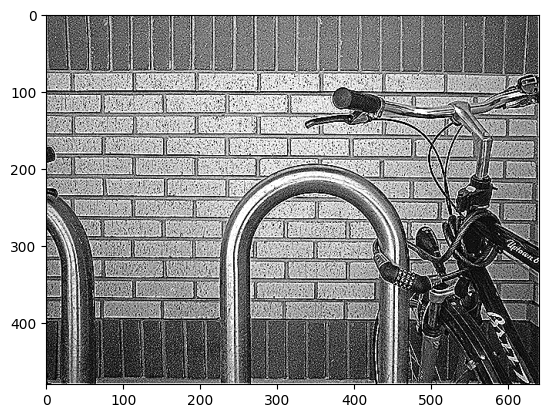

In [34]:
plt.imshow(img_sharp_clip_c, cmap='gray')

# **Actividad 3**

In [35]:
def fltr(imgnm,dimensionGauss,sigma,dimensionMediana):
  img = cv2.imread('Images/' + imgnm,cv2.IMREAD_GRAYSCALE)
  assert img is not None, "No se encontró la imagen señalada."

  fig0, ((ax0) ) = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
  ax0.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax0.set_title('Imagen original')
  ax0.axis('off')

  print ('Kernel Filtro Gaussiano')
  print(cv2.getGaussianKernel(	dimensionGauss, sigma))
  fig1, ((ax0) ) = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
  imgGauss = cv2.GaussianBlur(img,(dimensionGauss,dimensionGauss),sigma)
  ax0.imshow(cv2.cvtColor(imgGauss, cv2.COLOR_BGR2RGB))
  ax0.set_title('Imagen con filtro Gaussiano. Sigma : ' + str(sigma) + '. Dimension: ' + str(dimensionGauss) + ' x ' + str(dimensionGauss) )
  ax0.axis('off')

  fig2, ((ax0) ) = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
  imgMedian = cv2.medianBlur(img,dimensionMediana)
  ax0.imshow(cv2.cvtColor(imgMedian, cv2.COLOR_BGR2RGB))
  ax0.set_title('Imagen con filtro Mediana. Dimension: '+ str(dimensionMediana) + ' x ' + str(dimensionMediana))
  ax0.axis('off')

  fig3, ((ax0) ) = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
  imgGaussMedian = cv2.medianBlur(imgGauss,dimensionMediana)
  ax0.imshow(cv2.cvtColor(imgGaussMedian, cv2.COLOR_BGR2RGB))
  ax0.set_title('Imagen con filtro Gauss --> Mediana')
  ax0.axis('off')

Kernel Filtro Gaussiano
[[0.00147945]
 [0.00380424]
 [0.00875346]
 [0.01802341]
 [0.03320773]
 [0.05475029]
 [0.08077532]
 [0.106639  ]
 [0.12597909]
 [0.133176  ]
 [0.12597909]
 [0.106639  ]
 [0.08077532]
 [0.05475029]
 [0.03320773]
 [0.01802341]
 [0.00875346]
 [0.00380424]
 [0.00147945]]


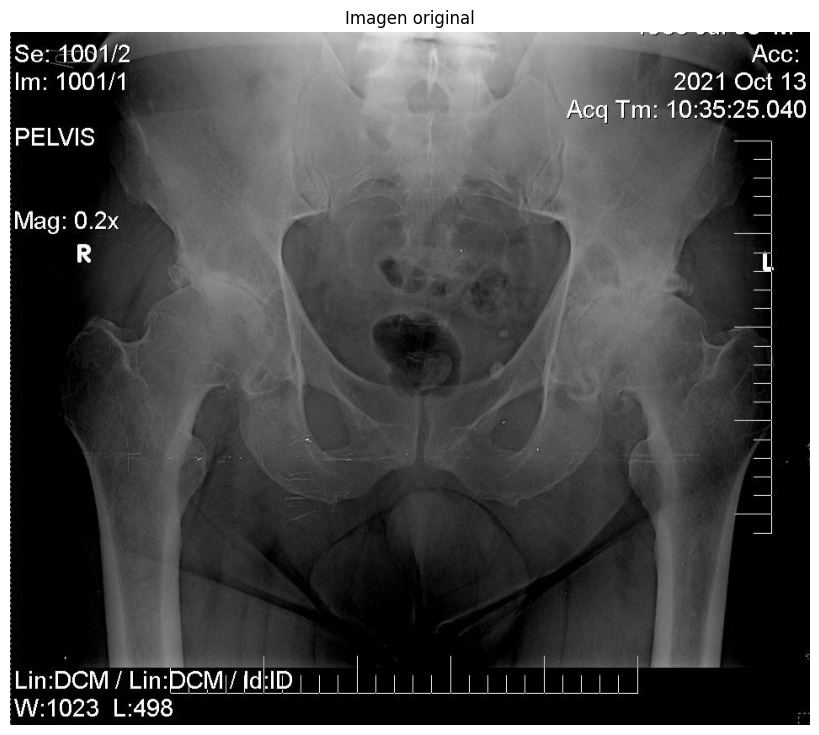

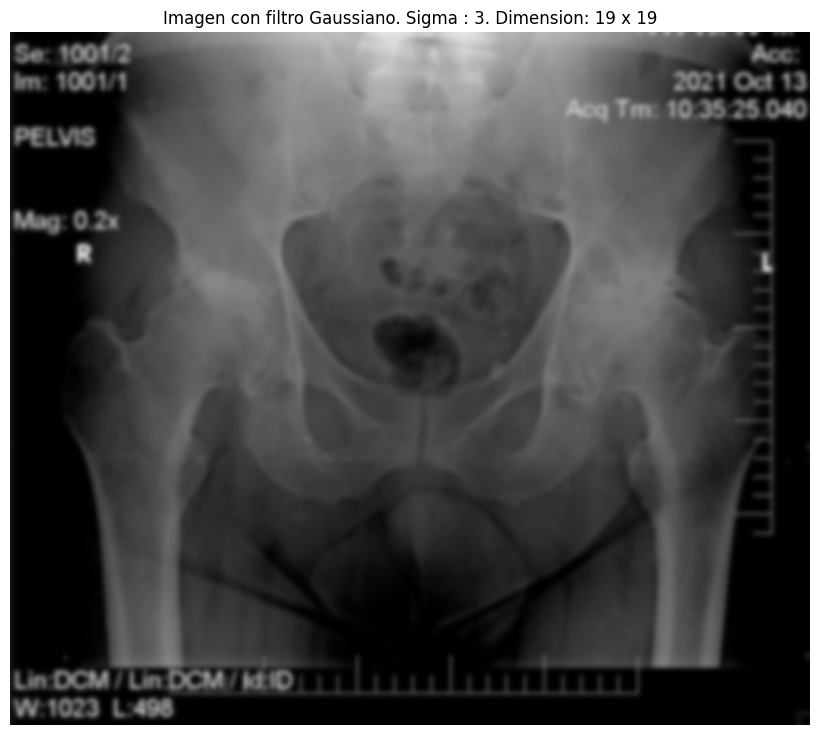

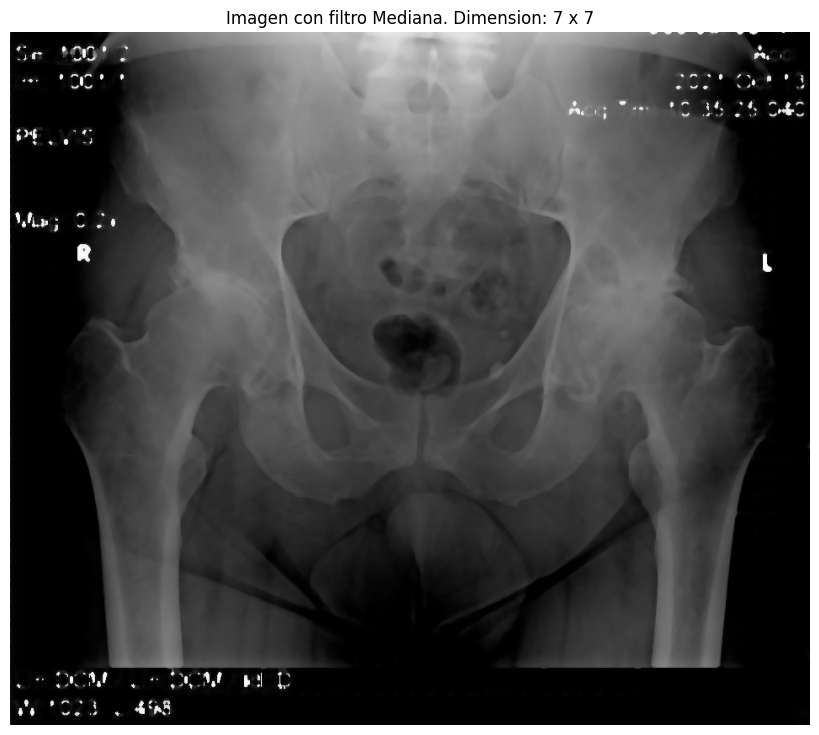

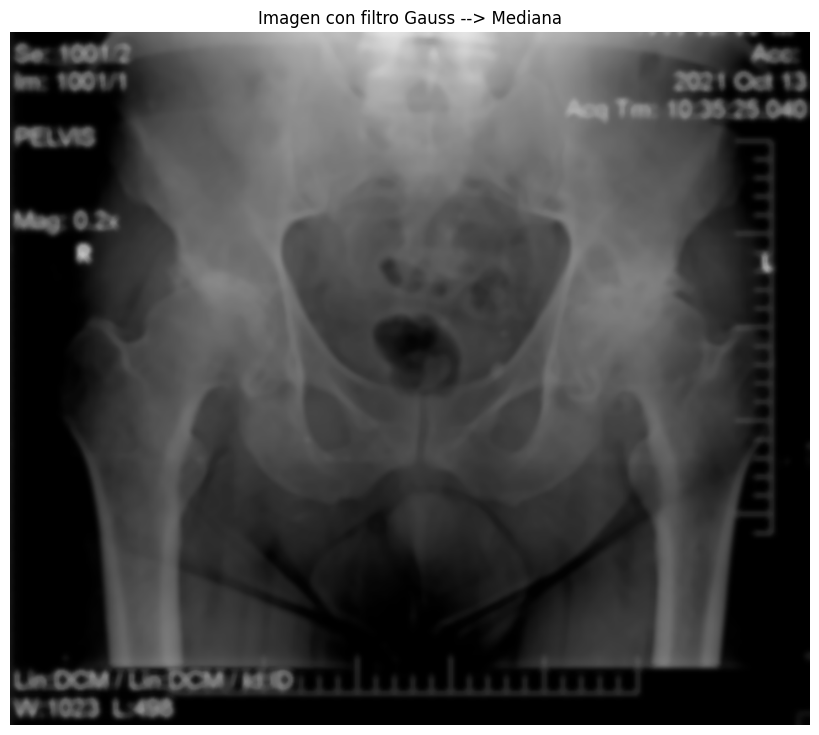

In [36]:
dimensionGaussian = 19
sigma = 3
dimensionMediana = 7
fltr('original6.jpg',dimensionGaussian,sigma,dimensionMediana)

# Aplicaciones del procesamiento de imágenes en el ámbito médico

El procesamiento de imágenes ha sido fundamental en los avances médicos, pues a la par de las técnicas de escaneo, se requiere el procesamiento de la información para poder convertirla en imágenes.

Durante este procesamiento y derivado de la misma naturaleza, las imágenes pueden no ser tan claras o con ruido que no permitan tener una imagen nítida o suficientemente clara para poder realizar un análisis o diagnóstico eficaz.

En este sentido, una aplicación muy utilizada es la Tomografía por Emisión de Positrones (PET, por sus siglas en inglés) el cual permite detectar lo que ocures a nivel molecular y celular.

El uso de filtros de imagen de difuminado como el Gaussiano y Mediana, permite quitar ruido de tipo "Salt & Pepper".

[1] Positron Emission Tomography (PET) (nd). Recuperado enero 27, 2024, de https://www.snmmi.org/Patients/Procedures/Content.aspx?ItemNumber=13526

[2] Positron Emission Tomography (PET). Mafraji. (noviembre 2023). Recuperado enero 27, 2024 de https://www.merckmanuals.com/home/special-subjects/common-imaging-tests/positron-emission-tomography-pet

[3] Apply a Gauss filter to an image with Python (nd). Recuperado enero 27, 2024, de https://www.geeksforgeeks.org/apply-a-gauss-filter-to-an-image-with-python/

[4] 3. The Gaussian kernel (nd). Recuperado enero 27, 2024 de https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf

[5] Gaussian Smoothing (nd). Recuperado enero 27, 2024 de https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

[6] Median Filter (nd). Recuperado enero 27, 2024 de https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm

[7] Image Filters in Python. Sekhon. (agosto 10, 2019). Recuperado enero 27, 2024 de https://towardsdatascience.com/image-filters-in-python-26ee938e57d2

[8] How to generate 2-D Gaussian array using NumPy? (nd). Recuperado enero 27, 2024 de https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/

[9] Image Filtering. OpenCV 3.4.20 (nd). Recuperado enero 27, 2024 de https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9

# **Bibliografia**

[1] Gonzalez, R. C., & Woods, R. E. (2017). Digital Image Processing, Global Edition. Pearson Higher Education.

[2] Ren, J., & Liu, X. (2015). On vectorization of deep convolutional neural networks for vision tasks. Proceedings of the . . . AAAI Conference on Artificial Intelligence, 29(1). https://doi.org/10.1609/aaai.v29i1.9488